In [1]:
# Import necessary libraries
from roboflow import Roboflow
from ultralytics import YOLO

In [ ]:
rf = Roboflow(api_key="M3G04YusuBRn3oLoZAF8")
project = rf.workspace("chessboard-ulleh").project("chessboard_model")
version = project.version(4)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chessboard_model-1 in yolov11:: 100%|██████████| 26/26 [00:00<00:00, 1662.53it/s]


In [3]:
# Step 2: Verify dataset structure
dataset_path = dataset.location  # Get the dataset location
data_yaml_path = dataset_path + "/data.yaml"  # Path to the data.yaml file

# Print dataset info
print(f"Dataset downloaded to: {dataset_path}")
print(f"Data configuration file: {data_yaml_path}")

Dataset downloaded to: c:\Users\samad\Coding\Tuwaiq\Chess Project\chessboard_model-1
Data configuration file: c:\Users\samad\Coding\Tuwaiq\Chess Project\chessboard_model-1/data.yaml


In [2]:
model = YOLO("weights/bestV4.pt")

In [42]:
# Evaluate the model on the test set
metrics = model.val(data=data_yaml_path, split="test")

Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cpu CPU (Intel Core(TM) i7-8550U 1.80GHz)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\samad\Coding\Tuwaiq\Chess Project\chessboard_model-1\test\labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


                   all          1         64      0.962      0.835      0.991      0.856
                 black          1         16      0.885          1      0.982      0.916
                 empty          1         32          1      0.833      0.995      0.896
                 white          1         16          1      0.673      0.995      0.755
Speed: 4.0ms preprocess, 336.8ms inference, 0.0ms loss, 39.9ms postprocess per image
Results saved to runs\detect\val2


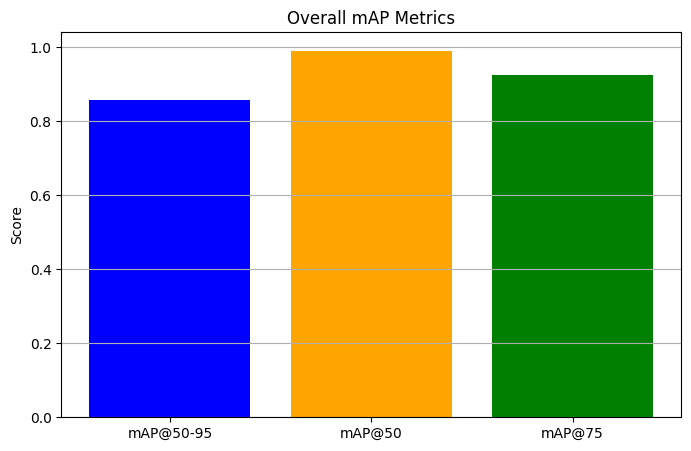

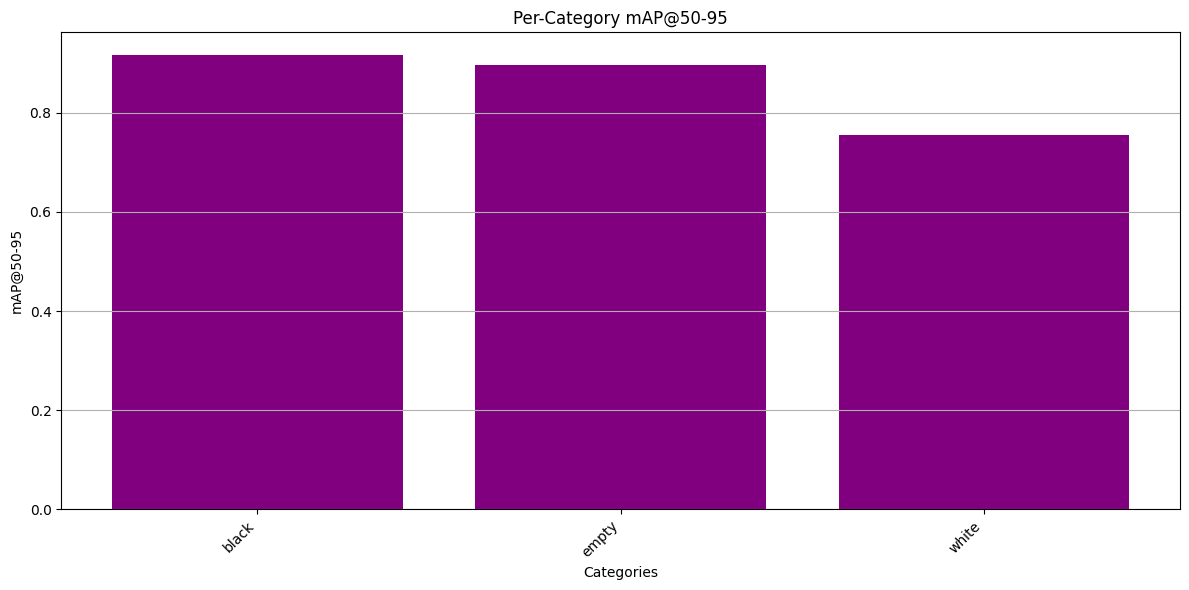

In [43]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Extract overall metrics
map50_95 = metrics.box.map  # Overall mAP 50-95
map50 = metrics.box.map50   # mAP at IoU 50
map75 = metrics.box.map75   # mAP at IoU 75
category_maps = metrics.box.maps  # List of mAP 50-95 for each category
class_names = metrics.names  # Dictionary mapping indices to class names

# Map class indices to names
class_labels = [class_names[i] for i in range(len(category_maps))]

# Overall mAP visualization
plt.figure(figsize=(8, 5))
plt.bar(['mAP@50-95', 'mAP@50', 'mAP@75'], [map50_95, map50, map75], color=['blue', 'orange', 'green'])
plt.title('Overall mAP Metrics')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

# Per-category mAP visualization
if category_maps.any():
    x_indices = np.arange(len(category_maps))

    plt.figure(figsize=(12, 6))
    plt.bar(x_indices, category_maps, color='purple')
    plt.title('Per-Category mAP@50-95')
    plt.xlabel('Categories')
    plt.ylabel('mAP@50-95')
    plt.xticks(x_indices, class_labels, rotation=45, ha="right")  # Label bars with class names
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()



In [3]:
results = model.predict('training images/IMG_0497.JPEG', conf=0.05)
results[0].show()


image 1/1 c:\Users\samad\Coding\Tuwaiq\capstone-project-team01\training images\IMG_0497.JPEG: 640x640 16 blacks, 32 emptys, 8 whites, 502.5ms
Speed: 38.3ms preprocess, 502.5ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)


In [45]:
import cv2
import numpy as np

def process_chessboard(image, detections):
    """
    Process the detected cells on the chessboard image.

    :param image: The original chessboard image.
    :param detections: List of bounding boxes with detection classes.
    :return: Annotated image with grid indices.
    """
    # Sort cells by their `y` coordinate (row-wise), then by `x` coordinate (column-wise)
    detections = sorted(detections, key=lambda box: (box[1], box[0]))  # Sort by (y1, x1)

    rows = []
    current_row = [detections[0]]
    row_threshold = 20  # Adjust based on resolution

    for i in range(1, len(detections)):
        if abs(detections[i][1] - current_row[0][1]) < row_threshold:
            current_row.append(detections[i])
        else:
            rows.append(current_row)
            current_row = [detections[i]]
    rows.append(current_row)

    # Sort each row by x-coordinate
    rows = [sorted(row, key=lambda box: box[0]) for row in rows]

    # Assign grid indices (a1 to h8)
    columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    rows_labels = ['1', '2', '3', '4', '5', '6', '7', '8']

    for row_idx, row in enumerate(rows):
        for col_idx, cell in enumerate(row):
            x1, y1, x2, y2 = map(int, cell)
            grid_label = f"{columns[col_idx]}{rows_labels[7 - row_idx]}"  # Chess notation (flip rows)
            
            # Draw the bounding box and grid label
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(image, grid_label, (x1 + 5, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return image

# Example Usage
results = model.predict('training images/IMG_0497.JPEG')
detections = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes as numpy array
orig_image = results[0].orig_img

# Process the image
annotated_image = process_chessboard(orig_image, detections)

# Save or display the result
cv2.imwrite("annotated_chessboard.jpg", annotated_image)
print("Annotated chessboard saved as 'annotated_chessboard.jpg'")



image 1/1 c:\Users\samad\Coding\Tuwaiq\Chess Project\training images\IMG_0497.JPEG: 640x640 6 blacks, 6 emptys, 281.1ms
Speed: 7.3ms preprocess, 281.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Annotated chessboard saved as 'annotated_chessboard.jpg'


In [46]:
results = model.predict('training images/IMG_0497.JPEG', conf=0.05)
detections = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes as numpy array
orig_image = results[0].orig_img

# Process the image
annotated_image = process_chessboard(orig_image, detections)
detections = sorted(detections, key=lambda box: (box[1], box[0]))


image 1/1 c:\Users\samad\Coding\Tuwaiq\Chess Project\training images\IMG_0497.JPEG: 640x640 16 blacks, 32 emptys, 17 whites, 424.1ms
Speed: 1.6ms preprocess, 424.1ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)


In [47]:
import torch

# Function to get the minimum x-coordinate
def get_min_x(xyxy):
    return xyxy[:, 0].min().item()  # Use .min() to find the minimum and .item() to get scalar

# Function to get the maximum x-coordinate (x + width)
def get_max_x(xyxy):
    return xyxy[:, 2].max().item()  # Use .max() for the maximum value

# Function to get the minimum y-coordinate
def get_min_y(xyxy):
    return xyxy[:, 1].min().item()

# Function to get the maximum y-coordinate (y + height)
def get_max_y(xyxy):
    return xyxy[:, 3].max().item()


In [48]:
xyxy = results[0].boxes.xyxy
min_x = get_min_x(xyxy)
max_x = get_max_x(xyxy) # x + width for all boxes
min_y = get_min_y(xyxy)
max_y = get_max_y(xyxy) # y + height for all boxes
print(f"Crop coordinates: ({min_x}, {min_y}), ({max_x}, {max_y})")


Crop coordinates: (242.5899658203125, 209.74713134765625), (1610.68115234375, 1637.7781982421875)


In [49]:
# Assuming results[0] contains predictions for a single image
predicted_classes = results[0].boxes.cls  # `cls` contains the class indices

# To map class indices to class names
class_names = model.names  # Assuming the model has a `names` attribute for class labels
predicted_class_names = [class_names[int(cls_idx)] for cls_idx in predicted_classes]

print("Predicted Class Indices:", predicted_classes.tolist())  # List of class indices
print("Predicted Class Names:", predicted_class_names)         # List of class names

Predicted Class Indices: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Predicted Class Names: ['black', 'black', 'black', 'black', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'black', 'black', 'empty', 'empty', 'empty', 'empty', 'empty', 'black', 'empty', 'white', 'white', 'empty', 'black', 'white', 'black', 'black', 'empty', 'white', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'white', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'white', 'empty', 'empty', 'black', 'black', 'black', 'black', 'white', 'white', 'empty', 'white', 'empty', 'empty', 'empty', 'white', 'white', 'black', 'black', 'white', 'white', 'white', 'white', 'white', 'white']


In [50]:
from PIL import Image

In [51]:
# Open the image using Pillow
image_path = 'training images/IMG_0497.JPEG'
img = Image.open(image_path)

# Crop the image
cropped_img = img.crop((min_x, min_y, max_x, max_y))  # (left, upper, right, lower)

# Save the cropped image
cropped_img.save('cropped_image.JPEG')
print("Cropped image saved as 'cropped_image.JPEG'.")

Cropped image saved as 'cropped_image.JPEG'.


In [52]:
def map_detections_to_spaces(boxes, spaces, classes, frame_shape, grid_rows, grid_cols):
    occupancy = {space: "initial" for space in spaces}
    index = 0
    for box in boxes:
        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2
        row = int(y_center * grid_rows / frame_shape[0])
        col = int(x_center * grid_cols / frame_shape[1])
        if 0 <= row < grid_rows and 0 <= col < grid_cols:
            space = f"{chr(65 + row)}{col + 1}"
            occupancy[space] = classes[index]
        index += 1

    return occupancy


In [53]:
grid_rows = 8
grid_cols = 8

# Create a grid for spaces
def create_grid(grid_rows, grid_cols):
    spaces = []
    for i in range(grid_rows):
        for j in range(grid_cols):
            spaces.append(f"{chr(65 + i)}{j + 1}")
    return spaces
spaces = create_grid(8, 8)

In [54]:
boxes = results[0].boxes.xyxy.cpu().numpy() if results else []

predicted_classes = results[0].boxes.cls  # `cls` contains the class indices
class_names = model.names  # Assuming the model has a `names` attribute for class labels
predicted_class_names = [class_names[int(cls_idx)] for cls_idx in predicted_classes]

In [55]:
map_detections_to_spaces(boxes, spaces, predicted_class_names, cropped_img.size, 8,8)

{'A1': 'initial',
 'A2': 'initial',
 'A3': 'initial',
 'A4': 'initial',
 'A5': 'initial',
 'A6': 'initial',
 'A7': 'initial',
 'A8': 'initial',
 'B1': 'initial',
 'B2': 'black',
 'B3': 'black',
 'B4': 'black',
 'B5': 'black',
 'B6': 'black',
 'B7': 'black',
 'B8': 'black',
 'C1': 'initial',
 'C2': 'black',
 'C3': 'black',
 'C4': 'black',
 'C5': 'black',
 'C6': 'black',
 'C7': 'black',
 'C8': 'black',
 'D1': 'initial',
 'D2': 'empty',
 'D3': 'empty',
 'D4': 'empty',
 'D5': 'empty',
 'D6': 'empty',
 'D7': 'empty',
 'D8': 'empty',
 'E1': 'initial',
 'E2': 'empty',
 'E3': 'empty',
 'E4': 'empty',
 'E5': 'empty',
 'E6': 'empty',
 'E7': 'empty',
 'E8': 'empty',
 'F1': 'initial',
 'F2': 'empty',
 'F3': 'empty',
 'F4': 'empty',
 'F5': 'empty',
 'F6': 'empty',
 'F7': 'empty',
 'F8': 'empty',
 'G1': 'initial',
 'G2': 'initial',
 'G3': 'initial',
 'G4': 'empty',
 'G5': 'empty',
 'G6': 'empty',
 'G7': 'empty',
 'G8': 'empty',
 'H1': 'initial',
 'H2': 'empty',
 'H3': 'empty',
 'H4': 'initial',
 'H5